In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,StratifiedKFold,StratifiedShuffleSplit,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

In [85]:
train_data=pd.read_csv('Train.csv')
test_data=pd.read_csv('Test.csv')
print(train_data.shape)
print(test_data.shape)
train_data.head()

(12079, 14)
(1202, 13)


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [86]:
print(train_data.shape)
x=train_data[~train_data.iloc[:,1:].duplicated(keep='first')]
#reemove confusing ids
train_data=train_data[~train_data.ID.isin(x[x.iloc[:,1:-1].duplicated(keep=False)].ID)]
print(train_data.shape)

(12079, 14)
(10841, 14)


In [87]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns

In [88]:
nullColumns(train_data)

Total Na values is 311 for column Gender
Total Na values is 3434 for column Car_Category
Total Na values is 6594 for column Subject_Car_Colour
Total Na values is 2384 for column Subject_Car_Make
Total Na values is 6082 for column LGA_Name
Total Na values is 6092 for column State




['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State']

In [89]:
def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na
print(percentMissingFeature(train_data))
print(percentMissingFeature(test_data))

Subject_Car_Colour    60.824647
State                 56.194078
LGA_Name              56.101836
Car_Category          31.676045
Subject_Car_Make      21.990591
Gender                 2.868739
dtype: float64
Subject_Car_Colour    57.986689
LGA_Name              54.575707
State                 54.575707
Car_Category          30.948419
Subject_Car_Make      20.632280
Gender                 3.410982
dtype: float64


In [90]:
set=['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State']
for i in set:
    train_data[i].fillna('n/a',inplace=True)
    test_data[i].fillna('n/a',inplace=True)

In [91]:
train_data.isnull().sum().sum(),test_data.isnull().sum().sum()

(0, 0)

In [92]:
train_data.describe()

,Age,No_Pol,target
count,10841.000000,10841.000000,10841.000000
mean,42.179043,1.287335,0.077115
std,102.659907,0.711785,0.266786
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Response')

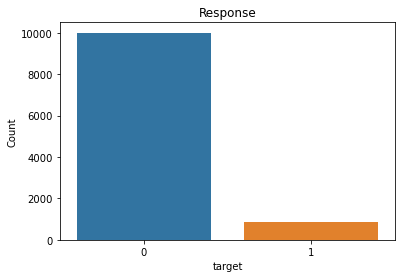

In [93]:
response = train_data.loc[:,"target"].value_counts().rename('Count')
plt.xlabel("target")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [94]:
train_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target'],
      dtype='object')

In [95]:
cat_features = ['Gender', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName']

cont_features = ['Age']

label = 'target'

In [96]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [97]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [98]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [99]:
combined_data['Age']=combined_data['Age'].apply(lambda x:0 if x<0 else x)

In [100]:
combined_data['Age']=combined_data['Age'].apply(lambda x:0 if x>130 else x)

In [101]:
combined_data.describe()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,train
count,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,10841.000000,12043.000000
mean,2.525201,43.503446,1.284398,9.492153,33.360957,56.865565,219.222619,89.087271,2.729552,0.077115,0.900191
std,1.286842,19.226395,0.702626,4.970449,17.088877,18.468693,72.919637,30.771788,2.081190,0.266786,0.299758
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,35.000000,1.000000,8.000000,25.000000,42.000000,165.000000,73.000000,1.000000,0.000000,1.000000
50%,3.000000,41.000000,1.000000,8.000000,45.000000,67.000000,265.000000,112.000000,1.000000,0.000000,1.000000
75%,3.000000,50.000000,1.000000,16.000000,45.000000,67.000000,265.000000,112.000000,5.000000,0.000000,1.000000
max,7.000000,128.000000,10.000000,16.000000,45.000000,74.000000,265.000000,112.000000,8.000000,1.000000,1.000000


In [102]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

#combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins']=age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='Age'>

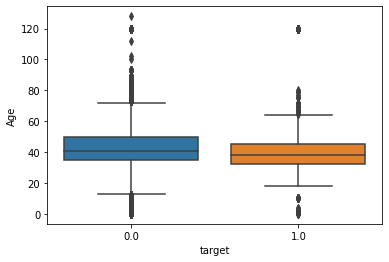

In [103]:
sns.boxplot(combined_data[combined_data['train']==1]['target'],combined_data[combined_data['train']==1]['Age'])

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='Age_Bins'>

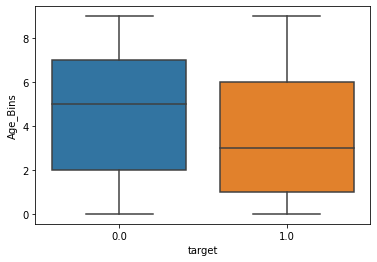

In [104]:
sns.boxplot(combined_data[combined_data['train']==1]['target'],combined_data[combined_data['train']==1]['Age_Bins'])

In [120]:
combined_data['Pol_Bins']=age_discretizer.fit_transform(combined_data['No_Pol'].values.reshape(-1,1)).astype(int)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='Pol_Bins'>

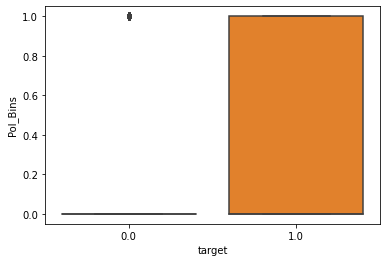

In [121]:
sns.boxplot(combined_data[combined_data['train']==1]['target'],combined_data[combined_data['train']==1]['Pol_Bins'])

<h1>feature counts

In [105]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Car_Category'].value_counts().to_dict()

combined_data['Car_counts'] = combined_data['Car_Category'].map(region_counts)

In [106]:
combined_data['Policy Start Date']=pd.to_datetime(combined_data['Policy Start Date'])
combined_data['Policy End Date']=pd.to_datetime(combined_data['Policy End Date'])
combined_data['First Transaction Date']=pd.to_datetime(combined_data['First Transaction Date'])

In [107]:
combined_data['start_end']=(combined_data['Policy End Date']-combined_data['Policy Start Date'])

In [108]:
combined_data=combined_data.drop(['First Transaction Date'],axis=1)

In [109]:
combined_data['start_year']=combined_data['Policy Start Date'].dt.year
combined_data['start_month']=combined_data['Policy Start Date'].dt.month
combined_data['start_day']=combined_data['Policy Start Date'].dt.day

combined_data['End_year']=combined_data['Policy End Date'].dt.year
combined_data['End_month']=combined_data['Policy End Date'].dt.month
combined_data['End_day']=combined_data['Policy End Date'].dt.day

In [110]:
combined_data=combined_data.drop(['Policy Start Date','Policy End Date'],axis=1)

In [111]:
combined_data['start_end']=combined_data['start_end'].astype(str).str.split(' ').str.get(0)
#test2['start_end']=test2['start_end'].astype(str).str.split(' ').str.get(0)

<h1>feature aggregations

In [126]:
combined_data['Nunq_LGAName_Per_State'] = combined_data.groupby('State')['LGA_Name'].transform('nunique') 

combined_data['Nunq_CC_SubCC']=combined_data.groupby(['Car_Category','Subject_Car_Colour'])['Subject_Car_Make'].transform('nunique')

combined_data['Nuniq_SCM_PN']=combined_data.groupby(['ProductName'])['Subject_Car_Make'].transform('nunique')

combined_data['Nuniq_CC_SCM_PN']=combined_data.groupby(['Car_Category','Subject_Car_Make'])['ProductName'].transform('nunique')

In [135]:
combined_data['start_end']=combined_data['start_end'].astype('int64')

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='start_end'>

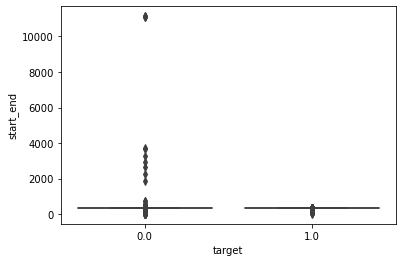

In [136]:
sns.boxplot(combined_data[combined_data['train']==1]['target'],combined_data[combined_data['train']==1]['start_end'])

In [138]:
combined_data['start_end_Bins']=age_discretizer.fit_transform(combined_data['start_end'].values.reshape(-1,1)).astype(int)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='start_end_Bins'>

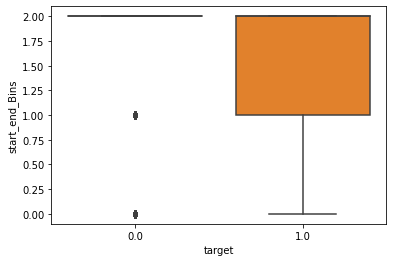

In [139]:
sns.boxplot(combined_data[combined_data['train']==1]['target'],combined_data[combined_data['train']==1]['start_end_Bins'])

In [140]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [141]:
cols = ['Gender', 'Car_Category','Age',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName','No_Pol']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [142]:
target = train_df['target']

train_df = train_df.drop(columns =['train','ID','target'])

test_df = test_df.drop(columns=['train','ID','target'])

In [143]:
test_size = 0.34

train_df

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Age_Bins,...,start_day,End_year,End_month,End_day,Pol_Bins,Nunq_LGAName_Per_State,Nunq_CC_SubCC,Nuniq_SCM_PN,Nuniq_CC_SCM_PN,start_end_Bins
0,3,30,1,8,4,67,265,112,1,1,...,14,2011,5,13,0,2,26,48,6,2
1,1,79,1,2,26,67,265,112,1,9,...,29,2011,11,28,0,2,20,48,6,2
2,3,43,1,8,32,67,265,112,1,5,...,21,2011,3,20,0,2,9,48,6,2
3,3,2,1,16,45,74,265,112,5,0,...,21,2011,8,20,0,2,33,50,8,2
4,3,37,2,16,45,74,265,112,1,3,...,21,2011,10,20,1,2,33,48,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,3,38,1,16,45,74,192,83,1,3,...,16,2011,9,15,0,1,33,48,8,2
6967,1,31,1,8,14,29,163,73,1,1,...,8,2011,8,7,0,35,3,48,5,2
6968,1,30,1,16,4,58,107,45,1,1,...,25,2011,5,24,0,1,17,48,3,2
6969,7,120,2,16,39,67,253,73,0,9,...,27,2011,2,26,1,35,16,27,6,2


In [144]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 4600 rows of holdout = 2371
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.278959	valid_0's auc: 0.737957
[200]	valid_0's binary_logloss: 0.275815	valid_0's auc: 0.738502
[300]	valid_0's binary_logloss: 0.276363	valid_0's auc: 0.738132
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.275509	valid_0's auc: 0.739924
LGB Val OOF AUC= 0.739924348083344
####################################################################################################
[ 229.1891124  2409.8509627   302.22536659  777.54886602  505.19996604
 1197.72824831 1340.77152177  642.30706422 1295.51385915  618.66709442
  188.43554476  317.63848452  451.25694459    0.          785.47773009
 1

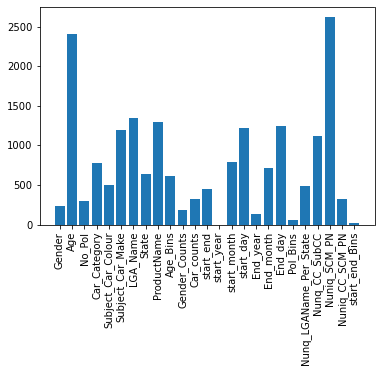

Fold 1
 rows of train = 4600 rows of holdout = 2371
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.277537	valid_0's auc: 0.753182
[200]	valid_0's binary_logloss: 0.270782	valid_0's auc: 0.761462
[300]	valid_0's binary_logloss: 0.268943	valid_0's auc: 0.764239
[400]	valid_0's binary_logloss: 0.268837	valid_0's auc: 0.764441
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.268774	valid_0's auc: 0.764017
LGB Val OOF AUC= 0.7640167364016737
####################################################################################################
Fold 2
 rows of train = 4600 rows of holdout = 2371
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[100]	valid_0's

In [148]:
%%time
##LightGBM

#cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                #'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                #'Annual_Premium','Vehicle_Age_License','Premium_Bins']

#cont_features = ['Age','Age_Bins']

probs_lgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])

    X_train_cv,y_train_cv = train_df.copy(), target.copy()
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=10000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.9,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = 1,
                                 importance_type='gain',
                                 reg_alpha=2,
                                 reg_lambda=2
                                 #cat_features=cat_features
                                )        
        
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=100)
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        probs_lgb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        avg_loss.append(clf.best_score_['valid_0']['binary_logloss'])

        print ('LGB Val OOF AUC=',roc)

        print('#'*100)

        if i==0:
            feature_importance(clf,X_train_cv)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 4600 rows of holdout = 2371
[0]	validation_0-auc:0.68841	validation_0-logloss:0.66668
[100]	validation_0-auc:0.74749	validation_0-logloss:0.27426
[200]	validation_0-auc:0.75201	validation_0-logloss:0.27163
[211]	validation_0-auc:0.75160	validation_0-logloss:0.27195
XGB Val OOF AUC= 0.752696420269642
####################################################################################################
[0.03417468 0.03990423 0.03572148 0.04500105 0.03757087 0.04343549
 0.04222501 0.03478733 0.08042845 0.04057874 0.02963757 0.03411492
 0.03328737 0.         0.03432703 0.03723148 0.05687946 0.03123992
 0.03273097 0.04302671 0.03318225 0.04178374 0.10142935 0.02979152
 0.02751035]


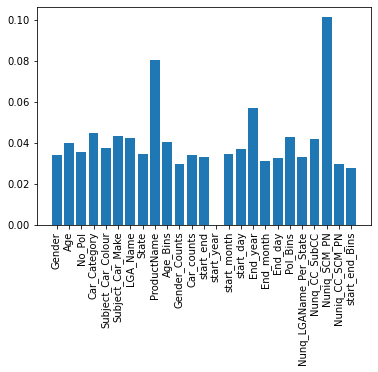

Fold 1
 rows of train = 4600 rows of holdout = 2371
[0]	validation_0-auc:0.67720	validation_0-logloss:0.66667
[100]	validation_0-auc:0.77306	validation_0-logloss:0.26868
[200]	validation_0-auc:0.77627	validation_0-logloss:0.26198
[225]	validation_0-auc:0.77455	validation_0-logloss:0.26252
XGB Val OOF AUC= 0.7792992688390177
####################################################################################################
Fold 2
 rows of train = 4600 rows of holdout = 2371
[0]	validation_0-auc:0.70115	validation_0-logloss:0.66671
[100]	validation_0-auc:0.75884	validation_0-logloss:0.27174
[200]	validation_0-auc:0.76337	validation_0-logloss:0.26751
[210]	validation_0-auc:0.76305	validation_0-logloss:0.26761
XGB Val OOF AUC= 0.7655382274629137
####################################################################################################
Fold 3
 rows of train = 4600 rows of holdout = 2371
[0]	validation_0-auc:0.67896	validation_0-logloss:0.66669
[100]	validation_0-auc:0.75439	valid

In [150]:
%%time

##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)
        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

In [151]:
train_df.columns

Index(['Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName', 'Age_Bins',
       'Gender_Counts', 'Car_counts', 'start_end', 'start_year', 'start_month',
       'start_day', 'End_year', 'End_month', 'End_day', 'Pol_Bins',
       'Nunq_LGAName_Per_State', 'Nunq_CC_SubCC', 'Nuniq_SCM_PN',
       'Nuniq_CC_SCM_PN', 'start_end_Bins'],
      dtype='object')

  0%|          | 0/1 [00:00<?, ?it/s]

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 4600 rows of holdout = 2371
0:	learn: 0.6690637	test: 0.6689512	best: 0.6689512 (0)	total: 209ms	remaining: 34m 49s
100:	learn: 0.2497541	test: 0.2794162	best: 0.2794162 (100)	total: 3.88s	remaining: 6m 20s
200:	learn: 0.2112165	test: 0.2695102	best: 0.2695035 (199)	total: 8.05s	remaining: 6m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2692048908
bestIteration = 225

Shrink model to first 226 iterations.
CatBoost Val OOF AUC= 0.7602848569375766
[ 2.22444619  7.17043943  1.85986227  4.2934863   1.95440041  4.72137003
  7.68561993  0.72731189 11.28305015  4.71923852  0.66855022  1.72171669
  1.39637826  0.31006831  4.42219366  5.19203244  1.46665147  6.09695141
  5.03289493  1.45970588  4.39185336  6.07717541  9.28378477  3.50089411
  2.33992394]


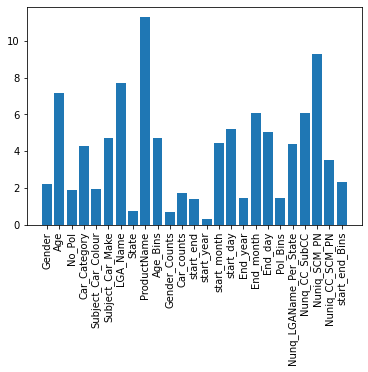

####################################################################################################
Fold 1
 rows of train = 4600 rows of holdout = 2371
0:	learn: 0.6691648	test: 0.6693163	best: 0.6693163 (0)	total: 10.1ms	remaining: 1m 41s
100:	learn: 0.2560989	test: 0.2799937	best: 0.2799937 (100)	total: 3.63s	remaining: 5m 55s
200:	learn: 0.2208363	test: 0.2697962	best: 0.2697569 (199)	total: 8.84s	remaining: 7m 11s
300:	learn: 0.1965234	test: 0.2663649	best: 0.2660738 (292)	total: 13.8s	remaining: 7m 25s
400:	learn: 0.1767773	test: 0.2658779	best: 0.2656126 (358)	total: 18.6s	remaining: 7m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.265612573
bestIteration = 358

Shrink model to first 359 iterations.
CatBoost Val OOF AUC= 0.7634757618021217
####################################################################################################
Fold 2
 rows of train = 4600 rows of holdout = 2371
0:	learn: 0.6693540	test: 0.6695720	best: 0.6695720 (0)	total: 2

In [152]:
%%time

##CatBoost

cat_features = ['Gender', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'Gender_Counts', 'Car_counts', 'start_end', 'start_year', 'start_month',
       'start_day', 'End_year', 'End_month', 'End_day', 'Pol_Bins', 'start_end_Bins']

cont_features = ['Age','Age_Bins']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )    

        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))
        


In [153]:
p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5

Response =  0.7*p2+0.3*p3

In [174]:
subs=[]
for i in Response:
    if i>0.12:
        subs.append(1)
    else:
        subs.append(0)

In [ ]:
sub=pd.DataFrame({'ID':test_data['ID'],
                 'target':preds})
sub.to_csv('lgbm_subs.csv',index=False)

In [197]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [198]:
x_trn,x_val,y_trn,y_val=train_test_split(X_train_cv,y_train_cv)

In [205]:
import lightgbm as lgb
train_data = lgb.Dataset(x_trn, label=y_trn)
test_data = lgb.Dataset(x_val, label=y_val)

param = {'objective': 'binary',
         'boosting': 'gbdt',  
         'learning_rate': 0.02, 
         'num_iterations': 3000,
         'max_depth': 10,
         'subsample':0.9,
         'colsample_bytree':0.4,
         'random_state':121,
         'importance_type':'gain',
         'reg_alpha':2,
         'reg_lambda':2
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data],feval=lgb_f1_score)

y_pred_lgbm = lgbm.predict(x_val)
#print('F1 score', (lgb_f1_score((y_pred_lgbm),)))

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 488, number of negative: 4740
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 5228, number of used features: 24
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093344 -> initscore=-2.273477
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1600]	valid_0's binary_logloss: 0.283518	valid_0's f1: 0.108108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

In [ ]:
print('F1 score', (lgb_f1_score((y_val), (y_pred_lgbm))))

In [209]:
preds=lgbm.predict(test_df)